<IPython.core.display.Javascript object>

HSV=(179,82,156) ➤ Detected: Red. Enter your expected color name: red
✅ Accuracy: 100% - Correct detection!
📸 Saved image at color_detection_results/Red_20250512_093744.jpg
Continue? (y/n): y


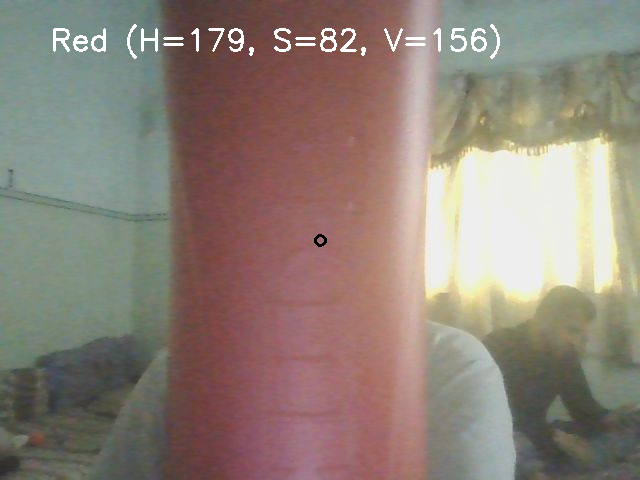

<IPython.core.display.Javascript object>

HSV=(66,20,65) ➤ Detected: Gray. Enter your expected color name: green
❌ Accuracy: 0% - Mismatch. Try again.
📸 Saved image at color_detection_results/Gray_20250512_093816.jpg
Continue? (y/n): y


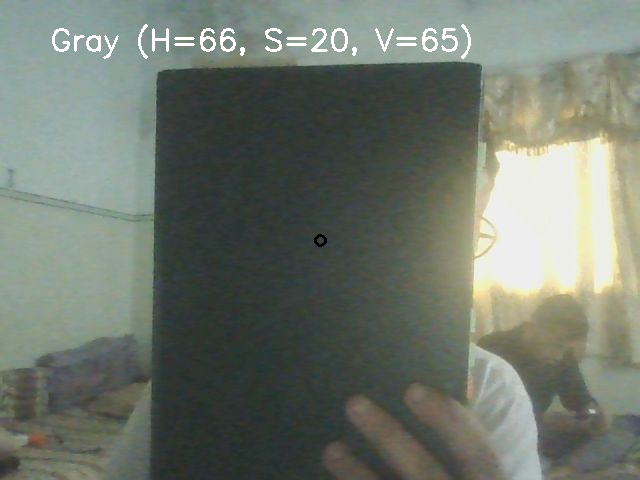

<IPython.core.display.Javascript object>

HSV=(94,72,99) ➤ Detected: Cyan. Enter your expected color name: blue
❌ Accuracy: 0% - Mismatch. Try again.
📸 Saved image at color_detection_results/Cyan_20250512_093850.jpg


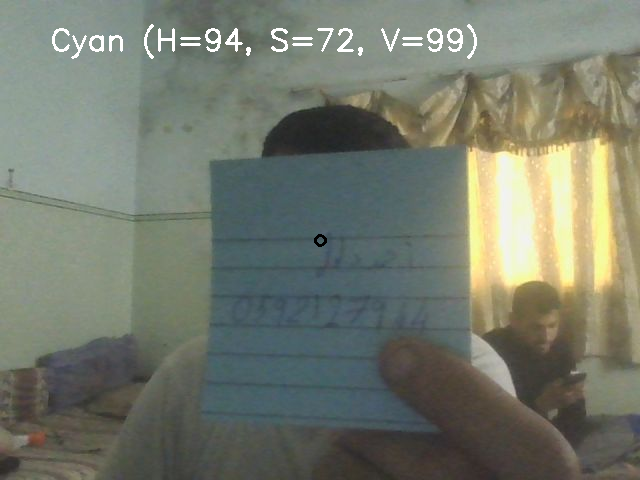

Continue? (y/n): n


In [4]:
# Real-Time Color Detection in HSV using Webcam in Google Colab
# Author: Based on community techniques + custom edits by Puma (OpenAI's ChatGPT)

import cv2
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Set up the output directory to save detected color images
def setup_output_dir():
    output_dir = "color_detection_results"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

# Save the frame image with the color name and timestamp
def save_frame(frame, color_name, output_dir):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{output_dir}/{color_name}_{timestamp}.jpg"
    cv2.imwrite(filename, frame)
    return filename

# Google Colab webcam capture setup (using JS)
def setup_camera_in_colab():
    from google.colab.patches import cv2_imshow
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    def take_photo(filename='photo.jpg', quality=0.8):
        js = Javascript('''
            async function takePhoto(quality) {
                const div = document.createElement('div');
                const capture = document.createElement('button');
                capture.textContent = 'Capture';
                div.appendChild(capture);

                const video = document.createElement('video');
                video.style.display = 'block';
                const stream = await navigator.mediaDevices.getUserMedia({video: true});
                document.body.appendChild(div);
                div.appendChild(video);
                video.srcObject = stream;
                await video.play();

                google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

                await new Promise((resolve) => { capture.onclick = resolve; });

                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                stream.getVideoTracks()[0].stop();
                div.remove();
                return canvas.toDataURL('image/jpeg', quality);
            }
        ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    return take_photo

# Match HSV values to basic color names manually
def get_hsv_color_name(h, s, v):
    # Basic rules from HSV ranges
    if v < 50:
        return "Black"
    if s < 50 and v > 200:
        return "White"
    if s < 50:
        return "Gray"

    if h < 15 or h >= 165:
        return "Red"
    elif 15 <= h < 35:
        return "Orange"
    elif 35 <= h < 50:
        return "Yellow"
    elif 50 <= h < 85:
        return "Green"
    elif 85 <= h < 125:
        return "Cyan"
    elif 125 <= h < 145:
        return "Blue"
    elif 145 <= h < 165:
        return "Magenta"

    return "Unknown"

# Main function
def main():
    import google.colab
    from google.colab.patches import cv2_imshow

    # Setup output folder
    output_dir = setup_output_dir()

    # Setup webcam capture
    take_photo = setup_camera_in_colab()

    while True:
        filename = take_photo()
        img = cv2.imread(filename)

        # Get center pixel
        h, w, _ = img.shape
        cx, cy = w // 2, h // 2

        # Convert BGR to HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h_val, s_val, v_val = hsv_img[cy, cx]

        # Detect color
        detected_color = get_hsv_color_name(h_val, s_val, v_val)

        # Ask user for expected color to calculate accuracy
        expected = input(f"HSV=({h_val},{s_val},{v_val}) ➤ Detected: {detected_color}. Enter your expected color name: ").strip().capitalize()

        # Accuracy check
        if expected == detected_color:
            print("✅ Accuracy: 100% - Correct detection!")
        else:
            print("❌ Accuracy: 0% - Mismatch. Try again.")

        # Draw detection info on image
        label = f"{detected_color} (H={h_val}, S={s_val}, V={v_val})"
        cv2.putText(img, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.circle(img, (cx, cy), 5, (0, 0, 0), 2)

        # Save and show image
        saved_path = save_frame(img, detected_color, output_dir)
        print(f"📸 Saved image at {saved_path}")
        cv2_imshow(img)

        # Break loop?
        choice = input("Continue? (y/n): ").strip().lower()
        if choice != 'y':
            break

if __name__ == "__main__":
    main()
